# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [8]:
import tensorflow as tf
from tensorflow import keras

2023-06-11 22:25:02.428668: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-11 22:25:02.627314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 22:25:03.502622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read files

In [4]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
# y_train = pd.read_csv('dades/processed/training_label.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()
#X_train.drop(columns=['ctx0'], axis=1, inplace=True)

X_val1 = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
# y_val1 = pd.read_csv('dades/processed/validation_label.csv', index_col='index')
X_val1 = X_val1.reset_index(drop=True)
y_val1 = X_val1.ctx0.copy()
#X_val1.drop(columns=['ctx0'], axis=1, inplace=True)

X_val2 = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
# y_val2 = pd.read_csv('dades/processed/testing_label.csv', index_col='index')
X_val2 = X_val2.reset_index(drop=True)
y_val2 = X_val2.ctx0.copy()
#X_val2.drop(columns=['ctx0'], axis=1, inplace=True)


CPU times: user 24.2 s, sys: 2.47 s, total: 26.6 s
Wall time: 27 s


# Run pipeline

In [5]:
X_train.columns

Index(['station_id', 'year', 'month', 'dayofweek', 'day', 'dayofyear', 'hour',
       'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4', 'festius',
       'festius_sun', 'festius_sun_sat', 'weekend', 'VALOR_TM_D5',
       'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5', 'VALOR_PPT_D5',
       'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5', 'VALOR_DVM10_D5',
       'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5', 'VALOR_HRN_D5',
       'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2', 'VALOR_TX_X2',
       'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2', 'VALOR_HRN_X2',
       'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4', 'VALOR_HRM_X4',
       'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4', 'VALOR_VVM10_X4',
       'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4', 'VALOR_HRX_X4',
       'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4', 'VALOR_TM_X8',
       'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8', 'VALOR_PPT_X8',
       'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8', 'VALOR_DVM1

In [6]:
columns_meteo = ['VALOR_TM_X4', 'VALOR_PPT_X4']
# next iteration remove 'month', 'dayofyear', 'day', 'hour'  from cat columns 
class Config:
    num_attribs0 = ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4'] + columns_meteo
    cat_attribs0 = ['station_id', 'dayofweek', 'month', 'dayofyear', 'day', 'hour', 'festius_sun', 'weekend']
    # cat_attribs1 = []
    # gen_attribs0 = [] # year
    target_col = ['ctx0']

    epochs=50
    # 512
    batch_size=128
    seed=42
    embedding_dim=8
    lr=1e-4

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    

In [9]:
config=Config()
seed_everything(config.seed)

In [12]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
#     cat_attribs1 = config.cat_attribs1
#     gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
#     categorical_transformer1 = Pipeline(steps=[
#         ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
#         ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
#     ])
    
#     generic_transformer0 = Pipeline([
#         ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
#     ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
#             ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
#             ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [14]:
%%time 

# Build pipeline
pp = build_preprocessor(config)
pp.fit(X_train)


CPU times: user 1.97 s, sys: 209 ms, total: 2.17 s
Wall time: 2.19 s


ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
                                  'VALOR_TM_X4', 'VALOR_PPT_X4']),
                                ('cat0',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['station_id', 'dayofweek', 'month',
                                  'dayofyear', 'day', 'hour', 'festius_sun',
                                  'weekend'])])

# Predicción______________________________

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [15]:

print(keras.__version__)
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0
2.12.0
/device:GPU:0


2023-06-11 22:25:57.385361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 9810 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-06-11 22:25:57.579537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 9810 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11888120607222624978
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10286923776
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 56223976713711100
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [17]:
# clear previous session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
import concurrent.futures
import logging
import sys
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [19]:
from keras import backend as K
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=3,
    inter_op_parallelism_threads=3
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

2023-06-11 22:26:01.570885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9810 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [20]:
from keras.callbacks_v1 import TensorBoard
from keras.callbacks import ReduceLROnPlateau

In [22]:
def root_mean_squared_error(y_true, y_pred):
    y = K.cast(y_true, K.np.float32)
    y_hat = K.cast(y_pred, K.np.float32)
    return K.sqrt(K.mean(K.square(y_hat - y)))

In [23]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, add, Activation, dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import itertools

def build_model(category_num, category_cols, num_cols, K=8, l2=0.0, l2_fm=0.0):

    # Numerical features
    num_inputs = [Input(shape=(1,), name=col,) for col in num_cols]
    # Categorical features
    cat_inputs = [Input(shape=(1,), name=col,) for col in category_cols]

    inputs = num_inputs + cat_inputs

    flatten_layers=[]
    # Numerical featrue embedding
    for enc_inp, col in zip(num_inputs, num_cols):
        # num feature dense
        x = Dense(K, name = f'embed_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_layers.append(x)

    # Category feature embedding
    for enc_inp, col in zip(cat_inputs, category_cols):
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=K,
                            input_length=1,
                            name=f'embed_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        flatten_layers.append(flatten_c)
                
    # Feature interaction term
    fm_layers = []
    for emb1,emb2 in itertools.combinations(flatten_layers, 2):
        dot_layer = dot([emb1,emb2], axes=1)
        fm_layers.append(dot_layer)        

    # Linear term
    for enc_inp,col in zip(cat_inputs, category_cols):
        # embedding
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=1,
                            input_length=1,
                            name=f'linear_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        fm_layers.append(flatten_c)
                
    for enc_inp, col in zip(num_inputs, num_cols):
        x = Dense(1, name = f'linear_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        fm_layers.append(x)

    # Add all terms
    flatten = add(fm_layers)
    outputs = Activation('linear',name='outputs')(flatten)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model  

In [25]:
category_num = {col: X_train[col].nunique() for col in config.cat_attribs0}

In [26]:
category_num

{'station_id': 408,
 'dayofweek': 7,
 'month': 12,
 'dayofyear': 365,
 'day': 31,
 'hour': 24,
 'festius_sun': 2,
 'weekend': 2}

In [27]:
model =  build_model(category_num, config.cat_attribs0, config.num_attribs0, config.embedding_dim)# instance the model here

# compile the model here
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.lr, beta_1=0.9, beta_2=0.999),
    loss=root_mean_squared_error,
    metrics=[
        'RootMeanSquaredError',
        'MeanAbsoluteError',
        'MeanSquaredError'       
    ]
)

2023-06-11 22:27:06.846702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9810 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [28]:
# cb = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0,)]
# tensorboard=TensorBoard(log_dir="Model_log")
# define a call back
checkpoint_cb = keras.callbacks.ModelCheckpoint("./checkpoints/rcnn_model.h5", verbose=2, monitor='val_loss', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=2, restore_best_weights=True)


In [30]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=2,
    factor=0.4,  # Factor by which the LR is multiplied.
    min_lr=0.0000001  # Don't go below this value for LR.
)

In [31]:
feature_num = len(config.cat_attribs0 + config.num_attribs0)

In [33]:
tra_inputs = [pp.transform(X_train)[:, i] for i in range(feature_num)]

In [35]:
val_inputs = [pp.transform(X_val1)[:, i] for i in range(feature_num)]

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 station_id (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dayofweek (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 dayofyear (InputLayer)         [(None, 1)]          0           []                               
                                                                                              

 linear_month (Embedding)       (None, 1, 1)         12          ['month[0][0]']                  
                                                                                                  
 linear_dayofyear (Embedding)   (None, 1, 1)         365         ['dayofyear[0][0]']              
                                                                                                  
 linear_day (Embedding)         (None, 1, 1)         31          ['day[0][0]']                    
                                                                                                  
 linear_hour (Embedding)        (None, 1, 1)         24          ['hour[0][0]']                   
                                                                                                  
 linear_festius_sun (Embedding)  (None, 1, 1)        2           ['festius_sun[0][0]']            
                                                                                                  
 linear_we

                                                                                                  
 dot_24 (Dot)                   (None, 1)            0           ['embed_ctx1[0][0]',             
                                                                  'flatten_5[0][0]']              
                                                                                                  
 dot_25 (Dot)                   (None, 1)            0           ['embed_ctx1[0][0]',             
                                                                  'flatten_6[0][0]']              
                                                                                                  
 dot_26 (Dot)                   (None, 1)            0           ['embed_ctx1[0][0]',             
                                                                  'flatten_7[0][0]']              
                                                                                                  
 dot_27 (D

                                                                  'embed_VALOR_PPT_X4[0][0]']     
                                                                                                  
 dot_52 (Dot)                   (None, 1)            0           ['embed_ctx4[0][0]',             
                                                                  'flatten[0][0]']                
                                                                                                  
 dot_53 (Dot)                   (None, 1)            0           ['embed_ctx4[0][0]',             
                                                                  'flatten_1[0][0]']              
                                                                                                  
 dot_54 (Dot)                   (None, 1)            0           ['embed_ctx4[0][0]',             
                                                                  'flatten_2[0][0]']              
          

 dot_79 (Dot)                   (None, 1)            0           ['flatten[0][0]',                
                                                                  'flatten_3[0][0]']              
                                                                                                  
 dot_80 (Dot)                   (None, 1)            0           ['flatten[0][0]',                
                                                                  'flatten_4[0][0]']              
                                                                                                  
 dot_81 (Dot)                   (None, 1)            0           ['flatten[0][0]',                
                                                                  'flatten_5[0][0]']              
                                                                                                  
 dot_82 (Dot)                   (None, 1)            0           ['flatten[0][0]',                
          

                                                                                                  
 flatten_11 (Flatten)           (None, 1)            0           ['linear_dayofyear[0][0]']       
                                                                                                  
 flatten_12 (Flatten)           (None, 1)            0           ['linear_day[0][0]']             
                                                                                                  
 flatten_13 (Flatten)           (None, 1)            0           ['linear_hour[0][0]']            
                                                                                                  
 flatten_14 (Flatten)           (None, 1)            0           ['linear_festius_sun[0][0]']     
                                                                                                  
 flatten_15 (Flatten)           (None, 1)            0           ['linear_weekend[0][0]']         
          

                                                                  'dot_58[0][0]',                 
                                                                  'dot_59[0][0]',                 
                                                                  'dot_60[0][0]',                 
                                                                  'dot_61[0][0]',                 
                                                                  'dot_62[0][0]',                 
                                                                  'dot_63[0][0]',                 
                                                                  'dot_64[0][0]',                 
                                                                  'dot_65[0][0]',                 
                                                                  'dot_66[0][0]',                 
                                                                  'dot_67[0][0]',                 
          

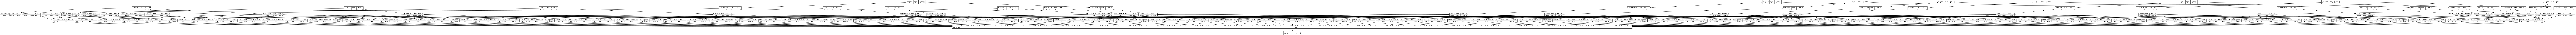

In [39]:
keras.utils.plot_model(model, "rcnn_model.png", show_shapes=True)

In [41]:
history = model.fit(
    x=tra_inputs,
    y=y_train,
    epochs= config.epochs,
    batch_size=config.batch_size ,
    validation_data=(val_inputs ,y_val1),
    callbacks=[checkpoint_cb, early_stopping_cb, learning_rate_reduction]
)


Epoch 1/50


2023-06-11 22:29:22.324217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float and shape [3541851]
	 [[{{node Placeholder/_21}}]]
2023-06-11 22:29:22.324650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype float and shape [3541851,1]
	 [[{{node Placeholder/_25}}]]
2023-06-11 22:29:30.183398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-11 22:29:30.201144: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9c4d0d75b0 initialized fo

27668/27671 [============================>.] - ETA: 0s - loss: 0.2950 - root_mean_squared_error: 0.5695 - mean_absolute_error: 0.1909 - mean_squared_error: 0.3243

2023-06-11 22:34:40.380297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float and shape [882910]
	 [[{{node Placeholder/_20}}]]
2023-06-11 22:34:40.380703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [882910]
	 [[{{node Placeholder/_10}}]]



Epoch 1: val_loss improved from inf to 0.12200, saving model to ./checkpoints/rcnn_model.h5
27671/27671 [==============================] - 340s 12ms/step - loss: 0.2950 - root_mean_squared_error: 0.5695 - mean_absolute_error: 0.1909 - mean_squared_error: 0.3243 - val_loss: 0.1220 - val_root_mean_squared_error: 0.1267 - val_mean_absolute_error: 0.0919 - val_mean_squared_error: 0.0161 - lr: 1.0000e-04
Epoch 2/50
27668/27671 [============================>.] - ETA: 0s - loss: 0.1099 - root_mean_squared_error: 0.1107 - mean_absolute_error: 0.0744 - mean_squared_error: 0.0122
Epoch 2: val_loss improved from 0.12200 to 0.11933, saving model to ./checkpoints/rcnn_model.h5
27671/27671 [==============================] - 325s 12ms/step - loss: 0.1099 - root_mean_squared_error: 0.1107 - mean_absolute_error: 0.0744 - mean_squared_error: 0.0122 - val_loss: 0.1193 - val_root_mean_squared_error: 0.1240 - val_mean_absolute_error: 0.0896 - val_mean_squared_error: 0.0154 - lr: 1.0000e-04
Epoch 3/50
2766

Epoch 16/50
27666/27671 [============================>.] - ETA: 0s - loss: 0.1083 - root_mean_squared_error: 0.1091 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0119
Epoch 16: val_loss improved from 0.11194 to 0.11005, saving model to ./checkpoints/rcnn_model.h5
27671/27671 [==============================] - 283s 10ms/step - loss: 0.1083 - root_mean_squared_error: 0.1091 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0119 - val_loss: 0.1100 - val_root_mean_squared_error: 0.1149 - val_mean_absolute_error: 0.0803 - val_mean_squared_error: 0.0132 - lr: 4.0000e-05
Epoch 17/50
27670/27671 [============================>.] - ETA: 0s - loss: 0.1083 - root_mean_squared_error: 0.1091 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0119
Epoch 17: val_loss did not improve from 0.11005
27671/27671 [==============================] - 283s 10ms/step - loss: 0.1083 - root_mean_squared_error: 0.1091 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0119 - val_loss: 0.1108 - val

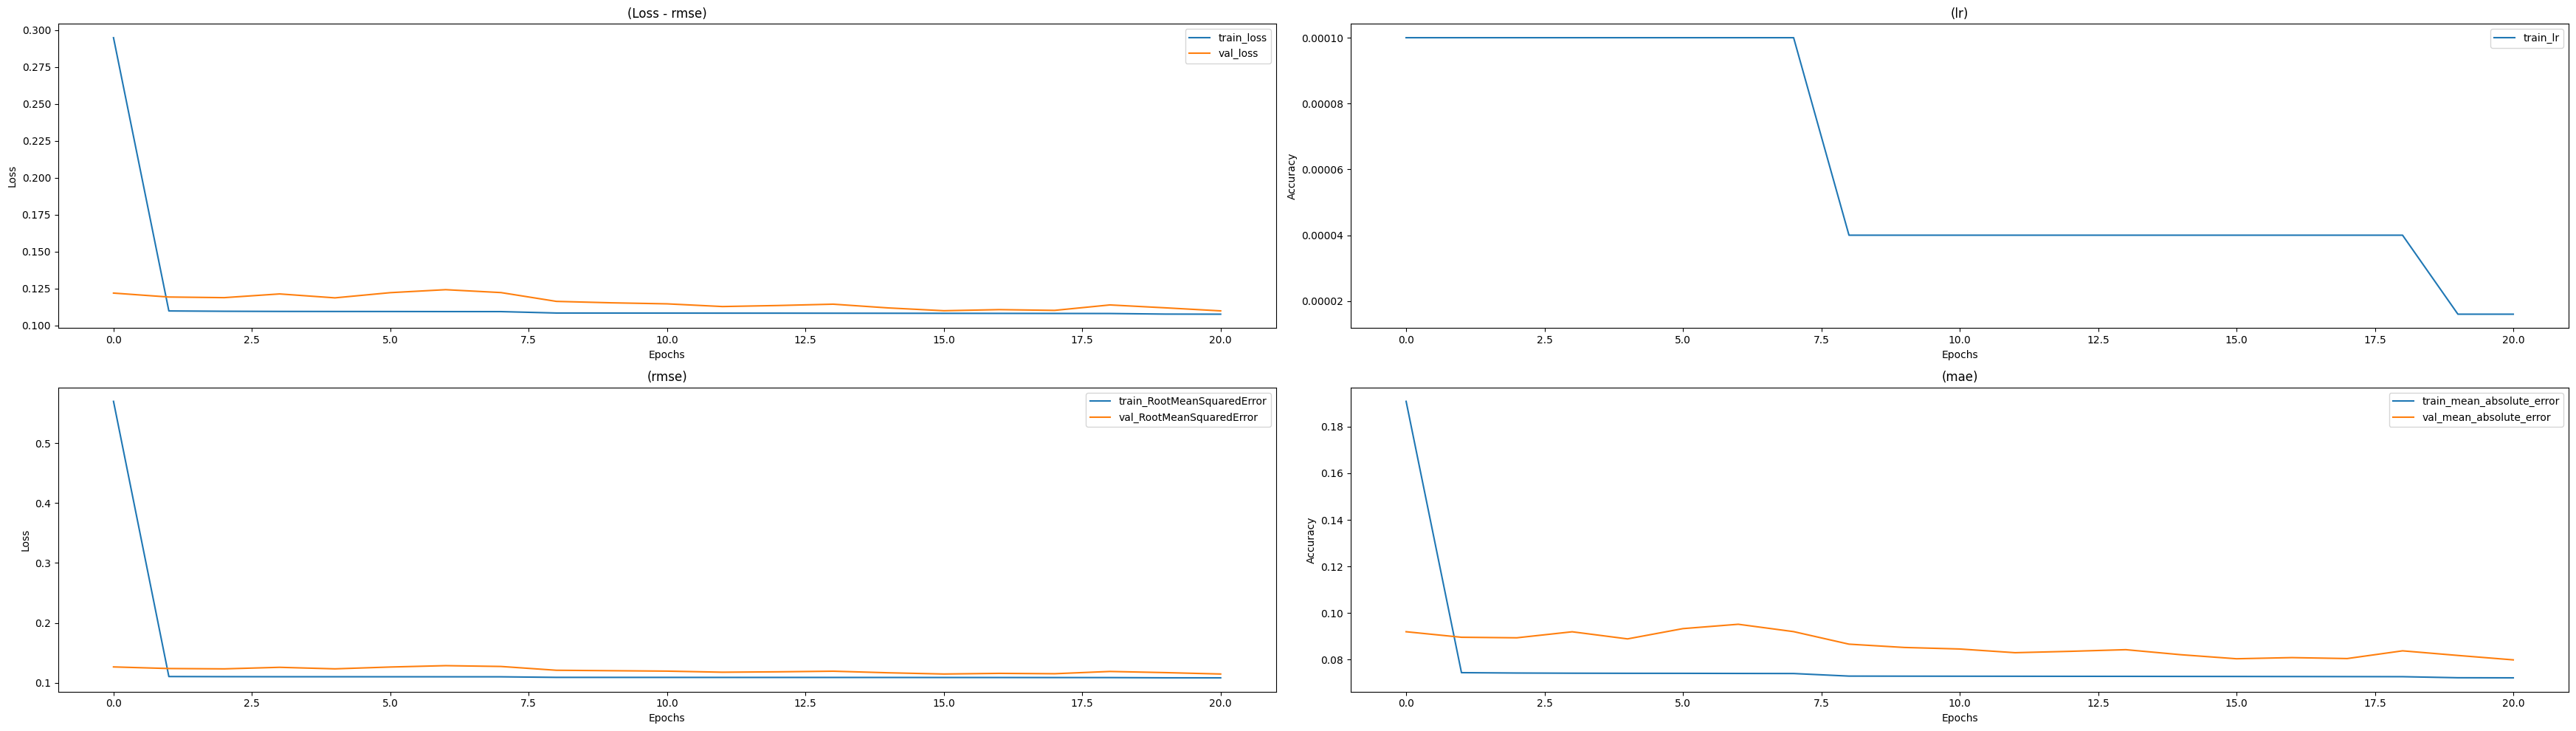

In [42]:
plot_history(history)

In [43]:
# It can be used to reconstruct the model identically.
best_model = keras.models.load_model("checkpoints/rcnn_model.h5", custom_objects={'root_mean_squared_error': root_mean_squared_error}, compile=True)

In [54]:
best_model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'root_mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [44]:
# Let's check:
np.testing.assert_allclose(
    model.predict(val_inputs), best_model.predict(val_inputs)
)

2023-06-12 01:08:58.056837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype float and shape [882910]
	 [[{{node Placeholder/_13}}]]
2023-06-12 01:08:58.057221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype float and shape [882910]
	 [[{{node Placeholder/_19}}]]


27591/27591 [==============================] - 85s 3ms/step


2023-06-12 01:10:34.966205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype float and shape [882910]
	 [[{{node Placeholder/_19}}]]
2023-06-12 01:10:34.966736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float and shape [882910]
	 [[{{node Placeholder/_22}}]]


27591/27591 [==============================] - 86s 3ms/step


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 882905 / 882910 (100%)
Max absolute difference: 0.20103455
Max relative difference: 42.318695
 x: array([[0.888318],
       [0.807085],
       [0.895757],...
 y: array([[0.88245 ],
       [0.811427],
       [0.905445],...

## Generate Sample

In [55]:
sample_data = pd.read_csv('dades/processed/kaggle_sample_data.csv')

In [56]:
sample_data

,index,station_id,month,day,hour,ctx4,ctx3,ctx2,ctx1,year,dayofweek,dayofyear,festius,festius_sun,festius_sun_sat,weekend,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8,capacity,percentage_docks_available
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66,0,0,0,0,12.5,18.4,8.0,59.0,0.0,959.4,15.1,3.5,259.0,11.5,262.0,91.0,46.0,961.7,956.7,12.8,20.9,5.8,71.0,93.0,40.0,13.9,20.6,8.7,61.0,0.0,1003.7,15.9,1.5,170.0,10.8,293.0,80.0,39.0,1006.1,1000.6,13.3,20.2,6.5,61.0,0.0,997.9,13.7,1.8,264.0,10.0,262.0,84.0,41.0,1000.2,995.0,27,0.797738
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,23,0.615065
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90,0,0,0,0,16.6,24.4,11.4,61.0,0.0,967.8,17.3,3.9,249.0,11.3,247.0,93.0,29.0,969.5,965.6,16.5,26.2,13.2,72.0,90.0,26.0,16.7,25.4,13.2,70.0,0.0,1011.9,16.8,2.5,28.0,9.7,300.0,96.0,25.0,1014.2,1009.8,17.1,26.3,12.0,67.0,0.0,1006.1,17.4,2.6,66.0,10.1,311.0,100.0,25.0,1008.3,1004.0,27,0.599193
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,24,0.699904
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63,0,0,1,1,8.2,15.5,3.8,61.0,0.0,970.6,17.8,5.5,294.0,12.9,314.0,73.0,40.0,972.1,969.2,10.0,15.5,5.1,61.0,81.0,37.0,10.9,14.6,7.3,52.0,0.0,1016.0,17.5,1.9,260.0,7.0,227.0,65.0,36.0,1017.6,1014.4,9.6,14.9,5.8,57.0,0.0,1010.1,17.3,2.3,287.0,9.1,291.0,80.0,38.0,1011.5,1008.6,27,0.792115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73,0,0,0,0,13.8,20.7,9.7,50.0,0.0,965.7,19.3,3.4,291.0,14.3,288.0,91.0,26.0,969.3,961.5,16.7,23.2,12.4,49.0,82.0,23.0,17.0,22.2,13.5,44.0,0.0,1010.1,19.5,3.3,345.0,15.6,337.0,73.0,21.0,1014.2,1005.2,16.5,22.3,10.9,42.0,0.0,1004.3,19.5,3.9,321.0,14.0,307.0,83.0,22.0,1008.3,1000.0,23,0.492037
54995,54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2,60,0,0,0,0,5.3,11.5,0.7,48.0,0.0,966.2,17.7,5.9,297.0,13.0,321.0,63.0,30.0,968.1,964.1,7.9,12.6,3.3,43.0,58.0,26.0,8.2,11.4,4.5,38.0,0.0,1011.9,17.6,2.0,284.0,8.5,231.0,49.0,25.0,1013.6,1009.5,7.0,11.8,1.7,41.0,0.0,1006.0,17.5,2.7,265.0,11.4,298.0,57.0,25.0,1007.6,1003.7,27,0.140021
54996,54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0,79,0,0,0,0,12.5,18.2,9.2,77.0,0.0,972.2,20.2,2.9,138.0,9.3,285.0,99.0,38.0,974.2,971.0,14.2,18.5,10.2,76.0,90.0,48.0,14.4,17.2,12.0,72.0,0.0,1017.2,19.9,1.7,130.0,6.6,106.0,87.0,43.0,1019.4,1015.8,14.1,19.3,9.6,70.0,0.0,1011.2,19.0,2.0,180.0,6.6,138.0,94.0,35.0,1013.5,1010.0,51,0.750484
54997,54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1,73,0,0,0,0,13.8,20.7,9

# apply pipeline

# Prediction 

In [61]:
test_inputs = [pp.transform(sample_data)[:, i] for i in range(feature_num)]

In [62]:
yhat = model.predict(test_inputs)


  55/1719 [..............................] - ETA: 4s

2023-06-12 01:19:08.575868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [54999]
	 [[{{node Placeholder/_11}}]]
2023-06-12 01:19:08.576432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_23' with dtype float and shape [54999]
	 [[{{node Placeholder/_23}}]]


1719/1719 [==============================] - 5s 3ms/step


In [63]:
yhat.shape

(54999, 1)

In [65]:
sample_data['percentage_docks_available'] = yhat

In [67]:
sample_data['percentage_docks_available'].to_csv('predicton_recurrent_nn.csv', header=True, index_label='index')